In [1]:
from obspy import read, read_inventory, UTCDateTime
from obspy.geodetics import locations2degrees
from rtergpy.waveforms import signal2noise
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

%matplotlib inline

KeyError: 'snr'

In [2]:
from rtergpy.run import defaults,event
from rtergpy.waveforms import theorPinfo,getwaves

Defaults=defaults()
Event=event()
Defaults.src="RASPISHAKE"
Defaults.network='AM'
Defaults.chan="EHZ"
Defaults.stationrange=[25,30]
station='SF4A5'

#Event.origin=[[32.94, 69.51, 15.1],UTCDateTime(2022, 6, 21, 20, 54, 39.1)]
Event.origin=[[-14.96, -70.43,  212.0],UTCDateTime(2022, 5, 26, 12, 2, 20)]

print(Defaults.waveparams)
%matplotlib inline

[[[0.00333333, 2.0], [0.5, 2.0]], [-60, 300], 1]


In [3]:
std,df=getwaves(Defaults=Defaults,Event=Event)

ERROR:  coudn't move directory to  /Users/leahjaffe/Desktop/Rtergpy/rterg_events/2022/2021092900/00.bak
Error:  Couldn't create directory:  /Users/leahjaffe/Desktop/Rtergpy/rterg_events/2022/2021092900/00
Checking for stations available within range from IRIS
Getting waves from RASPISHAKE


 55%|█████▍    | 6/11 [00:06<00:04,  1.10it/s]

AM.R8436.00.EHZ failed to download. Continuing..


 82%|████████▏ | 9/11 [00:09<00:01,  1.06it/s]

AM.RC15A.00.EHZ failed to download. Continuing..


 91%|█████████ | 10/11 [00:09<00:00,  1.10it/s]

AM.RCA97.00.EHZ failed to download. Continuing..


100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

rPtime =  60.0
Trace SNR =  nan 1
Trace SNR =  0.9999328074476559 2
Trace SNR =  0.9981565462050854 3
Trace SNR =  1.0007124506354397 4
Trace SNR =  1.0008271042219379 5
Trace SNR =  0.9990848487053492 6
Trace SNR =  1.000297650363265 7
Trace SNR =  1.0020307856936461 8
0  of  8 traces were kept above SNR threshold 10.0
writing  /Users/leahjaffe/Desktop/Rtergpy/rterg_events/2022/2021092900/00/pkls/Params_2021092900.pkl 
 /Users/leahjaffe/Desktop/Rtergpy/rterg_events/2022/2021092900/00/Params_2021092900.csv
writing  /Users/leahjaffe/Desktop/Rtergpy/rterg_events/2022/2021092900/00/pkls/Wavestream-raw_2021092900.pkl



/Users/leahjaffe/opt/anaconda3/envs/rtergpy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/leahjaffe/opt/anaconda3/envs/rtergpy/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
snrthreshold=10
pwindow=Defaults.waveparams[1]
from rtergpy.waveforms import signal2noise
for tr in std:
    total += 1
    snrtr=signal2noise(tr, rPtime=pwindow[0], window=pwindow[0]/2)
    if snrtr >= snrthreshold:
        kept += 1
        stnew += tr
st=stnew
print(kept," of ",total," traces were kept above SNR cutoff of ", snrthreshold)
    

ImportError: cannot import name 'signal2noise' from 'rtergpy.waveforms' (/Users/leahjaffe/opt/anaconda3/envs/rtergpy/lib/python3.9/site-packages/rtergpy/waveforms.py)

In [61]:
#modifying for a raspberry shake 
#time1&time2 need to be in the form(year,month,day,hour,min,sec)
def signal2noiseRS(tr, rPtime=60, window=10,**kwargs):
    #rPtime is relative time of P arrival to the beginning of the window [s]
    #window is size of window for calculating the pre-P noise and post P [s]  
    sps=int(tr.stats.sampling_rate)
    vel=tr.data   
    vel_square = np.square(vel)
    #plt.figure()
    #plt.plot(vel_square)
    #plt.ylabel('vel (m/s)^2')
    
    if window < rPtime:
        #noise before event 
        swin=int((rPtime/2-window/2)*sps-1)      
        ewin=int(swin+window*sps-1)
        noise = np.mean(vel_square[swin:ewin])      #based on RS sampling rate (another if statement for IRIS data sampling rates?)
        #print(noise)

        #signal after the pwave arrives
        pwin=int(rPtime*sps-1)
        epwin=int(pwin+window*sps-1)
        signal = np.mean(vel_square[pwin:epwin])     #based on RS sampling rate 
        #print(signal)

        ratio = signal/noise
        #print(ratio)
        return(ratio)  
    else :
        print("WARNING:  window ",window," is greater than rPtime", rPtime, "returning 0.")
        return 0
    
    
#signal2noiseRS(tr,rPtime=60,window=30)

10.0


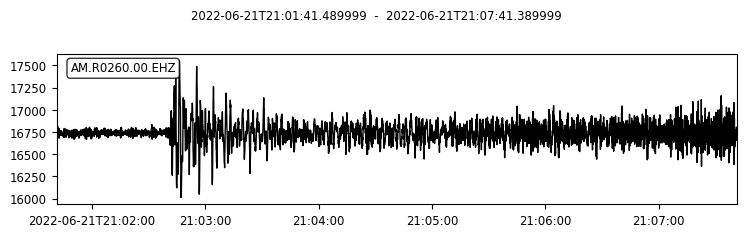

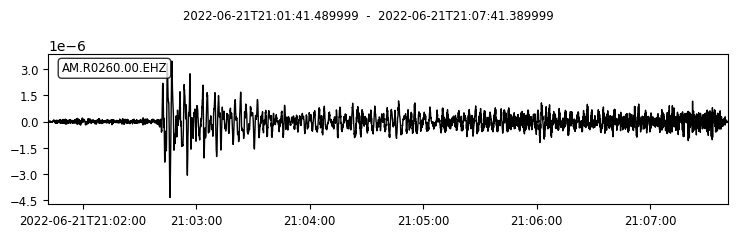

273.3412531972593

In [62]:
# test routine on one of the signals
tr=std[6].copy() #changed st to std 
tr.resample(10) # resample to 10sps independent of input sps
print(tr.stats.sampling_rate)
tr.plot()
#tr.stats

pre_filt = (0.1, 0.5, 5.0, 10.0) #sample rate is 100
tr.remove_response(output = 'VEL', pre_filt = pre_filt)

# may remove
tr.detrend('demean')           # preprocess data
tr.detrend('linear')
tr.detrend('demean')           # preprocess data
tr.plot();
signal2noiseRS(tr,rPtime=60,window=30)

In [63]:
pre_filt = (0.1, 0.5, 5.0, 10.0) #sample rate is 100
snr=np.zeros(0)
dist=np.zeros(0)
for tr in std.copy():
    tr.resample(10) # resample to 10sps independent of input sps
    #print(tr.stats.sampling_rate)
    tr.remove_response(output = 'VEL', pre_filt = pre_filt)
    # may remove
    tr.detrend('demean')           # preprocess data
    tr.detrend('linear')
    tr.detrend('demean')           # preprocess data
    snr=np.append(snr,signal2noiseRS(tr,rPtime=60,window=rPtime/2))
    # grab distance info
    dist=np.append(dist,tr.stats.distdeg)

/home/ljaffe7/anaconda3/envs/rtergpy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ljaffe7/anaconda3/envs/rtergpy/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [52]:
#print(snr)

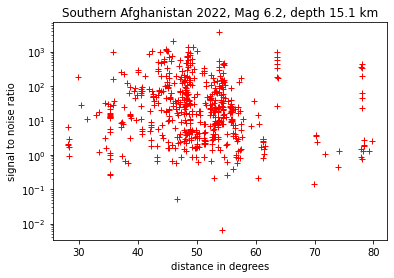

In [64]:
%matplotlib inline
#plt.semilogy(snr,'r.')
plt.semilogy(dist, snr,'r+')
plt.title('Southern Afghanistan 2022, Mag 6.2, depth 15.1 km')
plt.xlabel('distance in degrees')
plt.ylabel('signal to noise ratio')
plt.show()

In [ ]:
print(array)

In [ ]:
st[0][10].stats.sampling_rate

In [ ]:
std[0].plot()

# OLD Below

In [ ]:
#print(st[0][5].stats)
tr=std[6].copy() #changed st to std 
pre_filt = (0.1, 0.5, 5.0, 10.0) #sample rate is 100

#print(tr.stats.sampling_rate)

tr.resample(10) # resample to 10sps independent of input sps
print(tr.stats.sampling_rate)
tr.plot()
tr.stats

tr.remove_response(output = 'VEL', pre_filt = pre_filt)

# may remove
tr.detrend('demean')           # preprocess data
tr.detrend('linear')
tr.detrend('demean')           # preprocess data
    
tr.plot()

#tr.decimate(10, strict_length=False,no_filter=True)